# Кластеризация
__Суммарное количество баллов: 10__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [ ]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from typing import NoReturn
from collections import Counter

In [ ]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

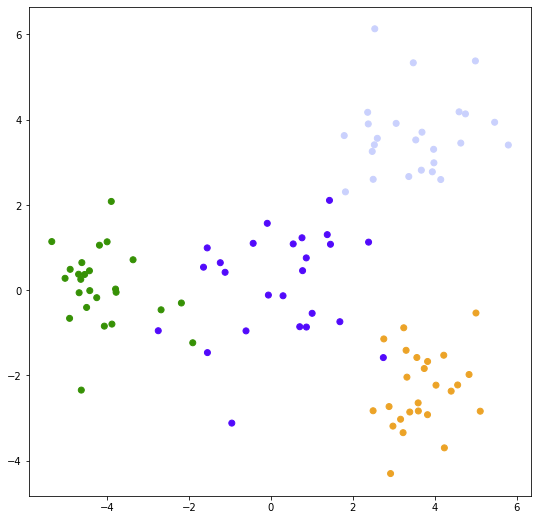

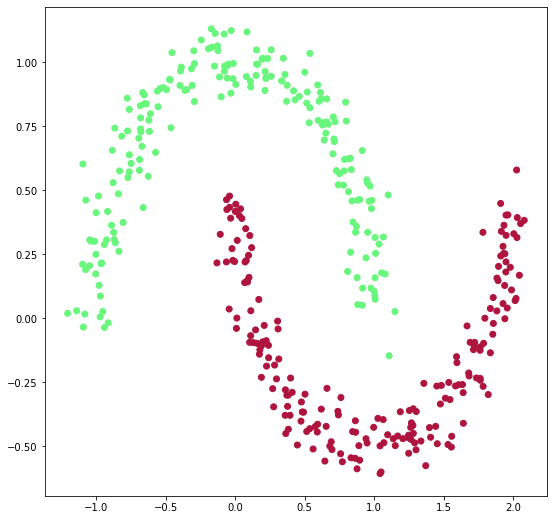

In [ ]:
X_1, true_labels1 = make_blobs(100, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
#X_1, true_labels1 = make_blobs(12, 2, centers=[[0, 0], [6, 0]])
visualize_clasters(X_1, true_labels1)
X_2, true_labels2 = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels2)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [ ]:
from task import KMeans

In [ ]:
class KMeans2:
    def __init__(self, n_clusters: int, init: str = "random", 
                 max_iter: int = 300):
        """
        
        Parameters
        ----------
        n_clusters : int
            Число итоговых кластеров при кластеризации.
        init : str
            Способ инициализации кластеров. Один из трех вариантов:
            1. random --- центроиды кластеров являются случайными точками,
            2. sample --- центроиды кластеров выбираются случайно из  X,
            3. k-means++ --- центроиды кластеров инициализируются 
                при помощи метода K-means++.
        max_iter : int
            Максимальное число итераций для kmeans.
        
        """

        self.init = init
        self.n_clusters = n_clusters
        self.max_iter = max_iter
    
    def getDistsParents(self, points):
      distsParentsTuple = []
      for point in points:
        distsParentsTuple.append(min([(np.linalg.norm(point - self.centers[i]), i) for i in range(len(self.centers)) ]))
      distsParentsTuple = np.array(distsParentsTuple)
      return distsParentsTuple[: , 0], distsParentsTuple[: , 1]
    
    def calculateCenters(self):
      _, parents = self.getDistsParents(self.X)
      sums = np.zeros((len(self.centers), self.X.shape[1]))
      counts = np.zeros(len(self.centers))
      for i in range(len(parents)):
        sums[int(parents[i])] += self.X[i]
        counts[int(parents[i])] += 1

      self.centers = []
      for i in range(len(counts)):
        if (counts[i] != 0):
          self.centers.append(sums[i] / counts[i])
      self.centers = np.array(self.centers)
    

    def plusPlus(self):
      if (len(self.centers) == 0):
        randomInd = int(np.random.uniform(len(self.X)))
        self.centers = np.array([self.X[randomInd]])

      while(len(self.centers) < self.n_clusters):
        dists, _ = self.getDistsParents(self.X)
        M = dists * dists
        M /= max(sum(M), 1)

        newCenter = self.X[np.random.choice(len(self.X), 1, p = M)]
        self.centers = np.vstack([self.centers, newCenter])


    def doIteration(self):
        self.calculateCenters()
        while (len(self.centers) < self.n_clusters):
          self.plusPlus()
          self.calculateCenters()


    def fit(self, X: np.array, y = None) -> NoReturn:
        """
        Ищет и запоминает в self.centroids центроиды кластеров для X.
        
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit обязаны принимать 
            параметры X и y, даже если y не используется).
        
        """
        self.X = X
        #self.y = y
        self.centers = np.array([])

        if (len(X) == self.n_clusters):
          self.centers = self.X
          return
              
        if (self.init == "random"):
          maxVec = [np.max(X[:, i]) for i in range(self.X.shape[1])]
          maxVec = np.array(maxVec)
          minVec = [np.min(X[:, i]) for i in range(self.X.shape[1])]  
          minVec = np.array(minVec)
          self.centers = [minVec + np.random.rand(self.X.shape[1]) * (maxVec - minVec) for i in range(self.n_clusters)] 
          self.centers = np.array(self.centers)

        if (self.init == "sample"):
          self.centers = self.X[np.random.choice(X.shape[0], self.n_clusters)]

        if (self.init == "k-means++"):
          self.plusPlus()

        for it in range(self.max_iter):
          self.doIteration()
        
        
    def predict(self, X: np.array) -> np.array:
        """
        Для каждого элемента из X возвращает номер кластера, 
        к которому относится данный элемент.
        
        Parameters
        ----------
        X : np.array
            Набор данных, для элементов которого находятся ближайшие кластера.
        
        Return
        ------
        labels : np.array
            Вектор индексов ближайших кластеров 
            (по одному индексу для каждого элемента из X).
        
        """
        _, parents = self.getDistsParents(X)
        return np.array([int(i) for i in parents])


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

In [ ]:
kmeans = KMeans2(n_clusters=6, init="k-means++")
kmeans.fit(X_1)
labels_1 = kmeans.predict(X_1)

print(labels_1)
visualize_clasters(X_1, labels_1)



kmeans = KMeans2(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)


NameError: ignored

In [ ]:
from sklearn.cluster import KMeans


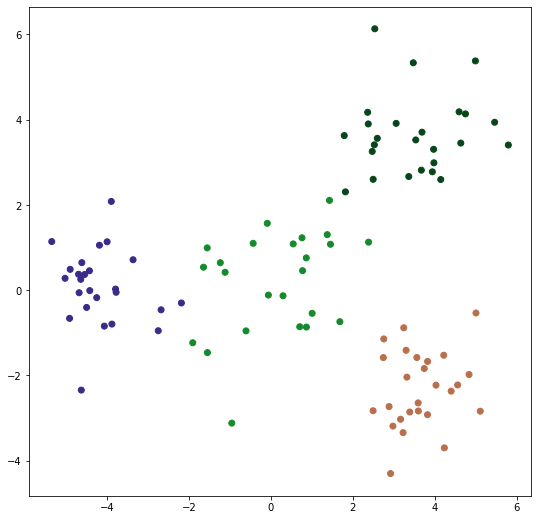

In [ ]:
kmeans2 = KMeans(n_clusters=4, random_state=0).fit(X_1)
labels = kmeans2.predict(X_1)
visualize_clasters(X_1, labels)


### Задание 2 (3 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [ ]:

from task import DBScan

In [ ]:
class DBScan:

    def __init__(self, eps: float = 0.5, min_samples: int = 5, 
                 leaf_size: int = 40, metric: str = "euclidean"):
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        
    def dfs(self, v):
      self.used[v] = 1
      self.res.add(v)
      for to in self.g[v]:
        self.res.add(to)
        if (self.used[to] == 0 and self.core[to] == 1):
          self.dfs(to)

    def startDFS(self, v):
      self.used = np.zeros(len(self.g))
      self.res = set()
      self.dfs(v)


    def fit_predict(self, X: np.array, y = None) -> np.array:
        self.kdtree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        self.g = self.kdtree.query_radius(X, r=self.eps)

        self.core = np.zeros(len(self.g))
        for i in range(len(self.g)):
          if self.min_samples <= len(self.g[i]):
            self.core[i] = 1
        
        labels = np.full(len(self.g), -1)

        k = 0
        for i in range(len(self.g)):
            if self.core[i] == 0:
                continue
            if labels[i] == (-1):
                self.startDFS(i)
                for v in self.res:
                    labels[v] = k
                k += 1
        return labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

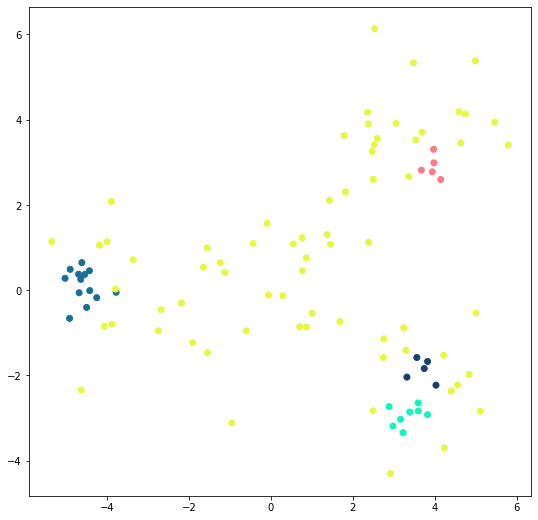

[0 1 1 1 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1
 0 0 1 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0
 0 1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 0
 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1
 1 0 0 0 1 1 0 0 1 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 0 1 1 0 1 1 1 1 0 1 0 1 0
 0 1 1 1 0 0 1 1 0 0 1 0 1 1 1 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 0 0
 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 0 0
 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 1 1
 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 0 0
 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 1
 1 1 0 0 0 1 0 1 1 1 0 0 1 1 0 0 0 1 0 1 1 1 0 1 0 1 0 1 1 1]


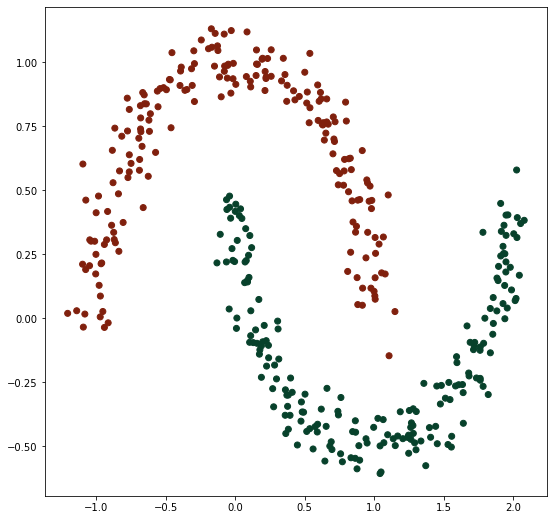

In [ ]:
dbscan = DBScan()
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(0.2)
labels = dbscan.fit_predict(X_2)
print(labels)
visualize_clasters(X_2, labels)

### Задание 3 (4 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [ ]:
import heapq

In [ ]:

class NodeLinked:
   def __init__(self, dataVal=None):
      self.dataVal = dataVal
      self.nextNode = None
 
class Linked:
  def __init__(self, val):
    self.headNode = NodeLinked(val)
    self.lastNode = self.headNode
    self.len = 1
  
  def appendBack(self, anotherLinked):
    self.lastNode.nextNode = anotherLinked.headNode
    self.lastNode = anotherLinked.lastNode
    self.len += anotherLinked.len

  def getList(self):
    res = []
    anotherNode = self.headNode
    while (anotherNode is not None):
      res.append(anotherNode.dataVal)
      anotherNode = anotherNode.nextNode
    return res
  
  

class AgglomerativeClustering1:
    def __init__(self, n_clusters: int = 16, linkage: str = "average"):
        """
        
        Parameters
        ----------
        n_clusters : int
            Количество кластеров, которые необходимо найти (то есть, кластеры 
            итеративно объединяются, пока их не станет n_clusters)
        linkage : str
            Способ для расчета расстояния между кластерами. Один из 3 вариантов:
            1. average --- среднее расстояние между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            2. single --- минимальное из расстояний между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            3. complete --- максимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
        """
        self.n_clusters = n_clusters
        self.linkage = linkage
        self.inf = 100000.0

    
    def recalcDistsAv(self, first, second):
      
      fL = self.clusters[first].len
      sL = self.clusters[second].len

      futureLen = fL + sL

      for i in self.aliveClusters:
        if (i == first or i == second):
          continue
        elif (i < first):
          temp = (self.dists[i][first] * fL + self.dists[i][second] * sL) / (futureLen)
          if (temp != self.dists[i][first]):
            self.dists[i][first] = temp
            heapq.heappush(self.rbt, (temp, i, first))
        elif (i < second):
          temp = (self.dists[first][i] * fL + self.dists[i][second] * sL) / (futureLen)
          if (temp != self.dists[first][i]):           
            self.dists[first][i] = temp
            heapq.heappush(self.rbt, (temp, first, i))
        else:
          temp = (self.dists[first][i] * fL + self.dists[second][i] * sL) / (futureLen)
          if (temp != self.dists[first][i]):
            self.dists[first][i] = temp 
            heapq.heappush(self.rbt, (temp, first, i))

    
    def recalcDistsComp(self, first, second):
      for i in self.aliveClusters:
        if (i == first or i == second):
          continue
        elif (i < first):
          temp = max(self.dists[i][first], self.dists[i][second])
          if (temp != self.dists[i][first]):
            self.dists[i][first] = temp
            heapq.heappush(self.rbt, (temp, i, first))
        elif (i < second):
          temp = max(self.dists[first][i], self.dists[i][second])
          if (temp != self.dists[first][i]):           
            self.dists[first][i] = temp
            heapq.heappush(self.rbt, (temp, first, i))
        else:
          temp = max(self.dists[first][i], self.dists[second][i])
          if (temp != self.dists[first][i]):
            self.dists[first][i] = temp 
            heapq.heappush(self.rbt, (temp, first, i))



    def recalcDistsSin(self, first, second):
      for i in self.aliveClusters:
        if (i == first or i == second):
          continue
        elif (i < first):
          temp = min(self.dists[i][first], self.dists[i][second])
          if (temp != self.dists[i][first]):
            self.dists[i][first] = temp
            heapq.heappush(self.rbt, (temp, i, first))
        elif (i < second):
          temp = min(self.dists[first][i], self.dists[i][second])
          if (temp != self.dists[first][i]):           
            self.dists[first][i] = temp
            heapq.heappush(self.rbt, (temp, first, i))
        else:
          temp = min(self.dists[first][i], self.dists[second][i])
          if (temp != self.dists[first][i]):
            self.dists[first][i] = temp 
            heapq.heappush(self.rbt, (temp, first, i))



    def unite(self):
      curMin, minInd1, minInd2 = heapq.heappop(self.rbt)
      while (self.aliveClustersInds[minInd1] == 0 or 
             self.aliveClustersInds[minInd2] == 0 or 
             self.dists[minInd1][minInd2] != curMin):
        curMin, minInd1, minInd2 = heapq.heappop(self.rbt)

      if (self.linkage == "average"):
        self.recalcDistsAv(minInd1, minInd2)
      elif (self.linkage == "single"):
        self.recalcDistsSin(minInd1, minInd2)
      elif (self.linkage == "complete"):
        self.recalcDistsComp(minInd1, minInd2)
      else:
        self.recalcDistsAv(minInd1, minInd2)

      self.clusters[minInd1].appendBack(self.clusters[minInd2])
      self.aliveClusters.remove(minInd2)
      self.aliveClustersInds[minInd2] = 0
      self.alive -= 1


    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        self.clusters = [Linked(i) for i in range(len(X))]


        self.X = X
        self.labels = np.zeros(len(X))
        self.aliveClusters = list(range(len(X)))
        self.aliveClustersInds = np.full(len(X), 1)
        self.alive = len(X)

        self.dists = np.zeros((len(X), len(X)), dtype = float)
        self.rbt = []

        for i in range(len(X)):
          for k in range(i + 1, len(X)):
            self.dists[i][k] = np.linalg.norm(self.X[i] - self.X[k])
            self.rbt.append((self.dists[i][k], i, k))
        
        heapq.heapify(self.rbt)
        
        while (self.alive != self.n_clusters):  
          self.unite()

        col = 0
        for i in self.aliveClusters:
          res = self.clusters[i].getList()
          self.labels[res] = col
          col += 1
        return np.array([int(l) for l in self.labels])


In [ ]:
import heapq

In [ ]:

agg_clustering = AgglomerativeClustering1(n_clusters=2, linkage="average")
labels = agg_clustering.fit_predict(X_3)
print(labels)

[0 0 0 1 1 1]


In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
X_3 = np.array([[1, 2], [1, 4], [1, 0], [4, 2], [4, 4], [4, 0]])

In [ ]:
X_4 = np.array([[1, 2], [1, 4], [1, 0], [1, 7], [6, 7], [6, 2], [6, 4], [6, 0]])

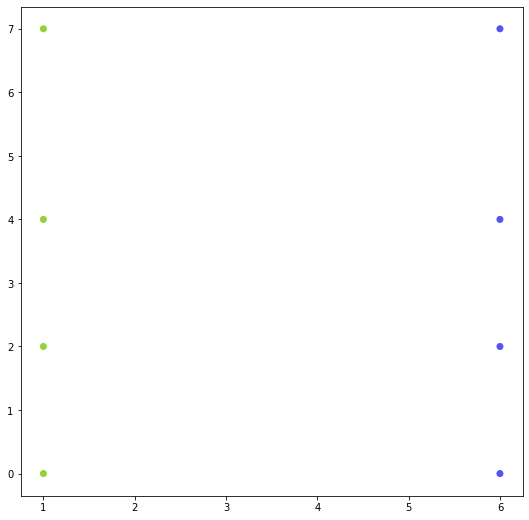

In [ ]:

agg_clustering = AgglomerativeClustering1(n_clusters=2, linkage="average")
labels = agg_clustering.fit_predict(X_4)
visualize_clasters(X_4, labels)



Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

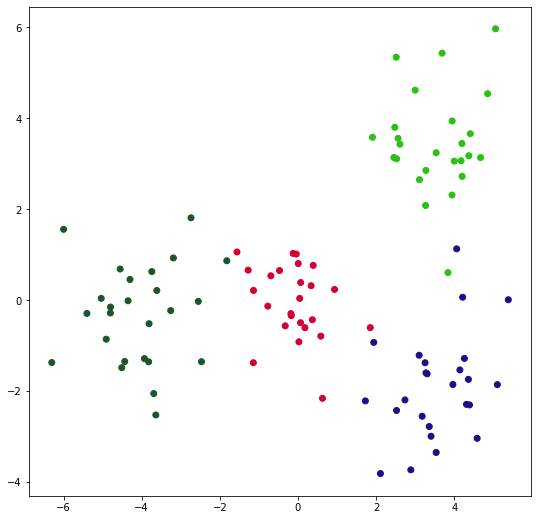

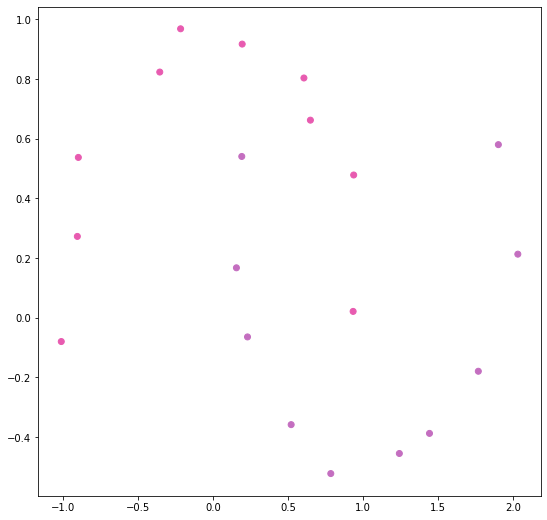

In [ ]:
X_1, true_labels1 = make_blobs(100, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels1)
X_2, true_labels2 = make_moons(20, noise=0.075)
visualize_clasters(X_2, true_labels2)

In [ ]:
from sklearn.cluster import AgglomerativeClustering

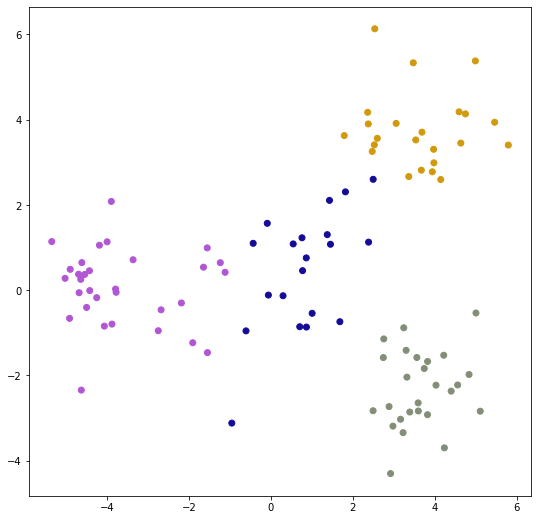

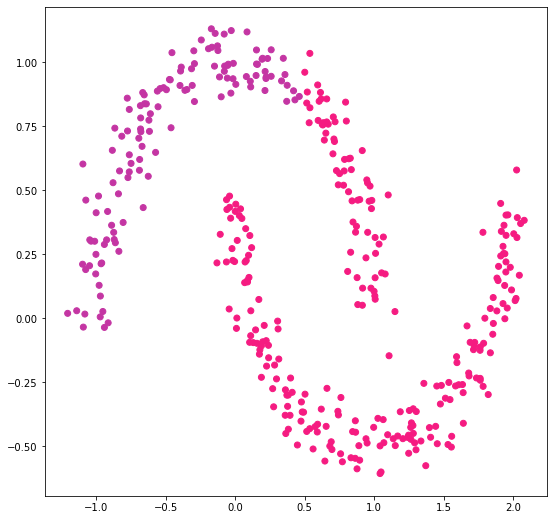

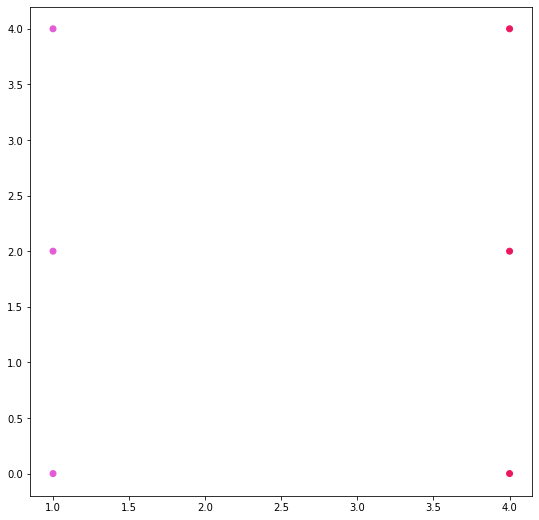

In [ ]:
clustering = AgglomerativeClustering(n_clusters = 4, linkage="average").fit(X_1)
labels = clustering.labels_
visualize_clasters(X_1, labels)

clustering = AgglomerativeClustering(n_clusters = 2, linkage="average").fit(X_2)
labels = clustering.labels_
visualize_clasters(X_2, labels)

clustering = AgglomerativeClustering(n_clusters = 2, linkage="average").fit(X_3)
labels = clustering.labels_
visualize_clasters(X_3, labels)


Counter({1: 31, 0: 26, 3: 23, 2: 20})


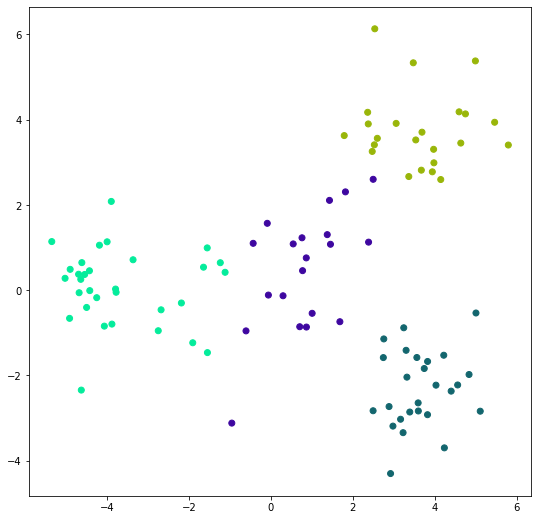

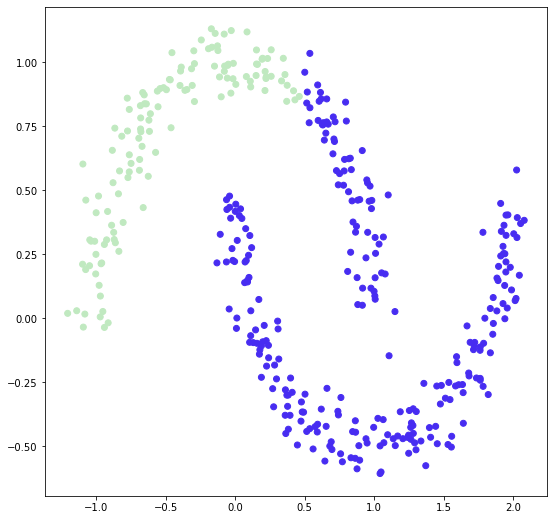

In [ ]:
agg_clustering = AgglomerativeClustering1(n_clusters=4, linkage="average")
labels = agg_clustering.fit_predict(X_1)
print(Counter(labels))
visualize_clasters(X_1, labels)



agg_clustering = AgglomerativeClustering1(n_clusters=2, linkage="average")
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)


### Дополнительно
Научимся кластеризовать цвета в изображении. Для начала используем OpenCV для того, чтобы считать изображение.

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [ ]:
def read_image(path: str) -> np.array:
    """
    Читает изображение.

    Parameters
    ----------
    path : str
        Путь к изображению.
    
    Return
    ------
    image : np.array
        Трехмерный массив размера (N, M, C), 
        где N и M - размеры изображения, 
        а C - количество цветов (3 для обычного изображения).
    """
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) / 255.
    return image

def show_image(image: np.array) -> NoReturn:
    """
    Выводит изображение

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    """
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image: np.array, path: str) -> NoReturn:
    """
    Сохраняет изображение.

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    path : str
        Путь для сохранения.
    """
    image = cv2.cvtColor(np.float32(image * 255), cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, image)

In [ ]:
show_image(read_image("./image.png"))

Теперь реализуем функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем применим ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [ ]:
def clusterize_image(image, n_clusters=8, color_scheme="rgb", show_cluster_statisitcs = False):
    orig_image = image
    if color_scheme == "hsv":
        image = cv2.cvtColor((image * 255).astype('float32'), cv2.COLOR_RGB2HSV)
        image /= 255.
    shape = image.shape
    
    small = image[::4,::4,:]
    image = image.reshape((-1, shape[-1]))
    orig_image = orig_image.reshape((-1, shape[-1]))
    X = small.reshape((-1, shape[-1]))
    kmeans = KMeans(max_iter=16, n_clusters=n_clusters, init="k-means++")
    kmeans.fit(X)
    clusters = kmeans.predict(image)
    cluster_colors = kmeans.centorids

    recolored = np.array([cluster_colors[c] for c in clusters]).reshape(shape)
    if color_scheme == "hsv":
        recolored *= 255
        recolored = cv2.cvtColor(recolored.astype('float32'), cv2.COLOR_HSV2RGB) / 255.
    if show_cluster_statisitcs:
        clusters_statistics(orig_image, cluster_colors, clusters)
    return recolored.reshape(shape)

In [ ]:
image = read_image("./img.jpg")
result = clusterize_image(image, n_clusters=4)
show_image(result)

In [ ]:
image = read_image("./img.jpg")
result = clusterize_image(image, n_clusters=8)
show_image(result)

In [ ]:
image = read_image("./img.jpg")
result = clusterize_image(image, n_clusters=16)
show_image(result)